In [1]:
import DS_Coma_Cluster_param as cc_prm
from DS_WCS_projections import *
from DS_healpix_fragmentation import n_max_flux_df
import pandas as pd
import numpy as np
from skimage.draw import circle, circle_perimeter
from matplotlib import pyplot as plt

In [2]:
c_wcs = custom_wcs(cc_prm.ra_center, cc_prm.dec_center)

/home/rt2122/L/git/data-segmentation-2/modules/DS_WCS_projections.py:39: RuntimeWarning: cdelt will be ignored since cd is present
  w1.wcs.cdelt = w.wcs.cdelt[:2]


In [3]:
desi_lis_data = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree_unfiltered.csv')
desi_lis_data.head()

,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,...,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS
0,8000,483713,1944p275,0,DEV,194.370715,27.376434,7.766236e+10,5.132580e+10,0.010509,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,8000,483713,1944p275,1,PSF,194.375536,27.377389,6.551291e+10,5.075641e+10,0.010561,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,4096
2,8000,483713,1944p275,3,REX,194.377318,27.377674,8.259466e+09,7.358640e+09,0.010576,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,8000,483713,1944p275,4,REX,194.368014,27.376374,1.218444e+10,1.040580e+10,0.010495,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,8000,483713,1944p275,5,PSF,194.376378,27.378784,1.483136e+09,1.303248e+09,0.010614,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [4]:
desi_lis_brightest = n_max_flux_df(desi_lis_data, 30, ['FLUX_G', 'FLUX_R', 'FLUX_Z'])

In [5]:
def draw_circles(coords, data, shape, coef):
    coef = shape[0] * coef / max(data)
    pic = np.zeros(shape)
    for i in range(len(data)):
        x, y = coords[i]
        circle_coords = circle(x, y, coef*data[i], shape=shape)
        pic[circle_coords] += 1
    return pic

In [6]:
pix_coords = c_wcs.all_world2pix(desi_lis_brightest['RA'], desi_lis_brightest['DEC'], 0)
pix_coords = np.array(pix_coords).T

In [7]:
pic_g = draw_circles(pix_coords, desi_lis_brightest['FLUX_G'], c_wcs.array_shape, 0.1)
pic_r = draw_circles(pix_coords, desi_lis_brightest['FLUX_R'], c_wcs.array_shape, 0.1)
pic_z = draw_circles(pix_coords, desi_lis_brightest['FLUX_Z'], c_wcs.array_shape, 0.1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


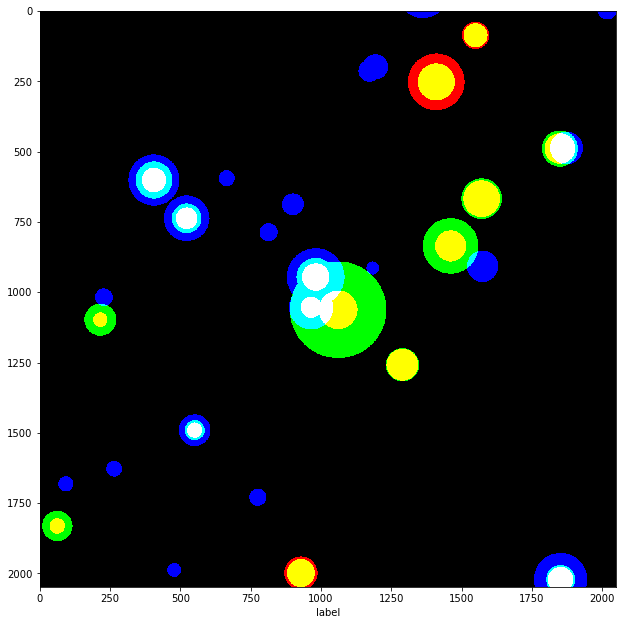

In [14]:
show_pic(np.dstack([pic_g, pic_r, pic_g_f]))

In [15]:
def find_radius_wcs(radius, wcs):
    def dist_between_pix(pix0, pix1):
        from astropy.coordinates import SkyCoord
        from astropy import units as u
        
        pix = np.stack([pix0, pix1])
        ra, dec = wcs.all_pix2world(pix[:,0], pix[:,1], 0)
        sc = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
        return sc[0].separation(sc[1]).degree
    
    cen_pix = np.array(wcs.array_shape, dtype=np.int32) // 2
    
    pix_rad = 1
    cur_pix = np.copy(cen_pix)
    cur_pix[0] -= 1
    
    if dist_between_pix(cen_pix, cur_pix) > radius:
        return pix_rad
    
    while cur_pix[0] >= 0:
        if dist_between_pix(cen_pix, cur_pix) > radius:
            break
        
        pix_rad += 1
        cur_pix[0] -= 1
    
    return pix_rad

In [16]:
r500_pix = find_radius_wcs(cc_prm.r500, c_wcs)
r500_pix

706

In [18]:
circle_per = circle_perimeter(1024, 1024, r500_pix, shape=(2048, 2048, 1)) 

In [19]:
pic = np.dstack([pic_g, pic_r, pic_g_f])

In [20]:
pic[circle_per] = 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


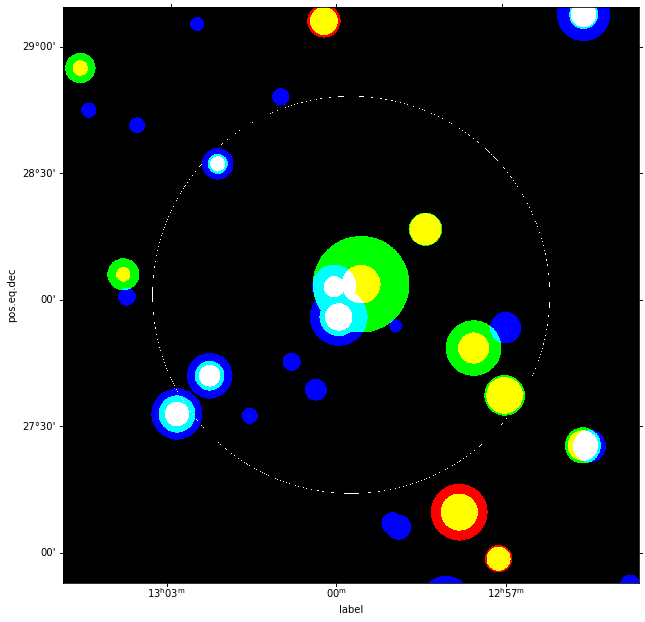

In [21]:
show_pic(pic, projection=c_wcs)

In [9]:
desi_lis_data_f = pd.read_csv('/home/rt2122/Data/coma_sweep/south/circle_2degree_filtered.csv')
desi_lis_data.head()

,RELEASE,BRICKID,BRICKNAME,OBJID,TYPE,RA,DEC,RA_IVAR,DEC_IVAR,EBV,...,GAIA_PHOT_BP_RP_EXCESS_FACTOR,GAIA_ASTROMETRIC_SIGMA5D_MAX,GAIA_ASTROMETRIC_PARAMS_SOLVED,PARALLAX,PARALLAX_IVAR,PMRA,PMRA_IVAR,PMDEC,PMDEC_IVAR,MASKBITS
0,8000,483713,1944p275,0,DEV,194.370715,27.376434,7.766236e+10,5.132580e+10,0.010509,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,8000,483713,1944p275,1,PSF,194.375536,27.377389,6.551291e+10,5.075641e+10,0.010561,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,4096
2,8000,483713,1944p275,3,REX,194.377318,27.377674,8.259466e+09,7.358640e+09,0.010576,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,8000,483713,1944p275,4,REX,194.368014,27.376374,1.218444e+10,1.040580e+10,0.010495,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,8000,483713,1944p275,5,PSF,194.376378,27.378784,1.483136e+09,1.303248e+09,0.010614,...,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
desi_lis_brightest_f = n_max_flux_df(desi_lis_data_f, 30, 
                                     ['FLUX_G', 'FLUX_R', 'FLUX_Z'])

In [11]:
pix_coords = c_wcs.all_world2pix(desi_lis_brightest_f['RA'], 
                                 desi_lis_brightest_f['DEC'], 0)
pix_coords = np.array(pix_coords).T

In [12]:
pic_g_f = draw_circles(pix_coords, desi_lis_brightest_f['FLUX_G'], c_wcs.array_shape, 0.05)

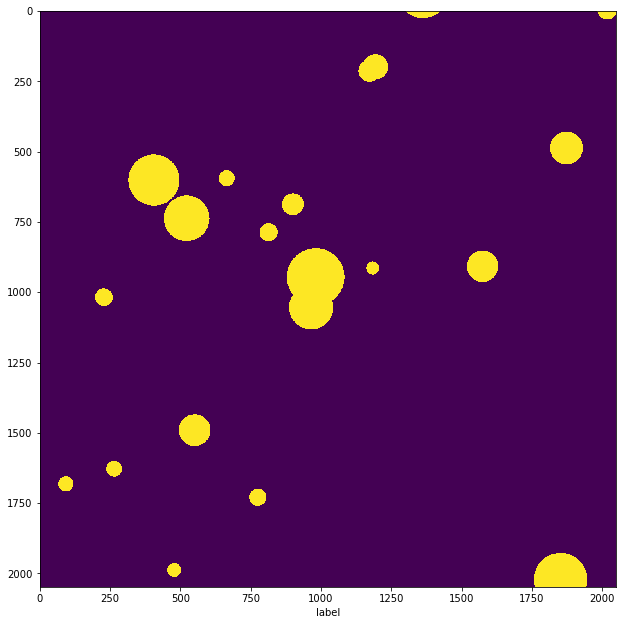

In [13]:
show_pic(pic_g_f)

In [22]:
circle_pic = np.zeros_like(pic_g)
circle_pic[circle_per] = 1

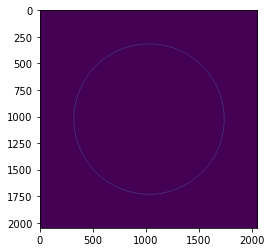

In [23]:
plt.imshow(circle_pic)

In [25]:
pic_fits = np.dstack([pic_g, circle_pic, pic_g_f])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


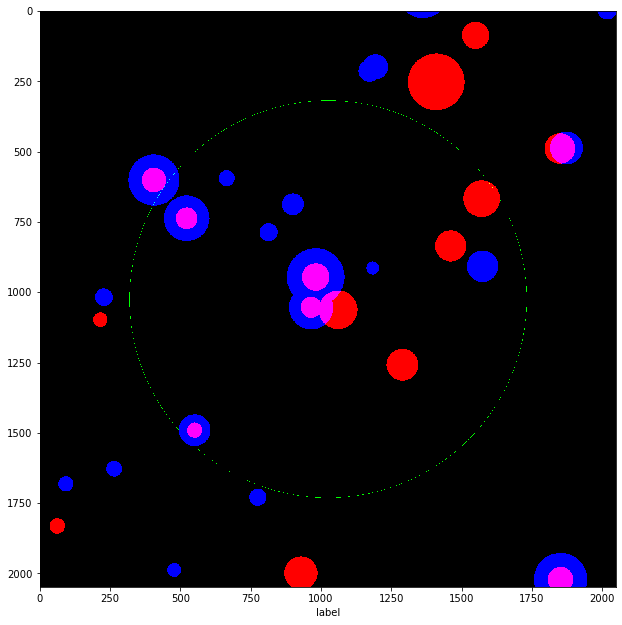

In [26]:
show_pic(pic_fits)

In [27]:
def pic2fits(pic, wcs, fitsname):
    from astropy.io import fits

    hdul = fits.HDUList([fits.PrimaryHDU(), 
        fits.ImageHDU(np.stack([pic[:,:,i] for i in range(pic.shape[-1])]), 
                     header=wcs.to_header())])
    hdul.writeto(fitsname)

In [28]:
pic2fits(pic_fits, c_wcs, '/home/rt2122/Data/coma_sweep/south/g_filter_no_filter.fits')